In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
!pip install yfinance

In [6]:
import yfinance as yf
ticker = 'AAPL'
startdate = '2020-01-01'
enddate = '2025-01-01'
df= yf.download(ticker,start=startdate,end=enddate)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620827,72.681274,71.373203,71.627077,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487862,72.526549,70.783263,71.034724,118387200
2020-01-07,72.146935,72.753816,71.926907,72.497522,108872000
2020-01-08,73.307503,73.609737,71.849525,71.849525,132079200


In [8]:
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])



In the context of stock market data, as likely present in the `df` DataFrame you obtained using `yfinance.download()`, the columns `Close`, `High`, `Low`, `Open`, and `Volume` represent specific data points for a given trading period (usually a day):

*   **Open:** The price at which the first trade of the trading period occurred.
*   **High:** The highest price at which the stock traded during the trading period.
*   **Low:** The lowest price at which the stock traded during the trading period.
*   **Close:** The price at which the last trade of the trading period occurred. This is often considered the most important price as it's used to calculate the previous day's performance and often used in financial analysis.
*   **Volume:** The total number of shares traded during the trading period. This indicates the level of activity and interest in the stock.

These five data points are fundamental to technical analysis and understanding the price movements and liquidity of a stock.

<Axes: xlabel='Date'>

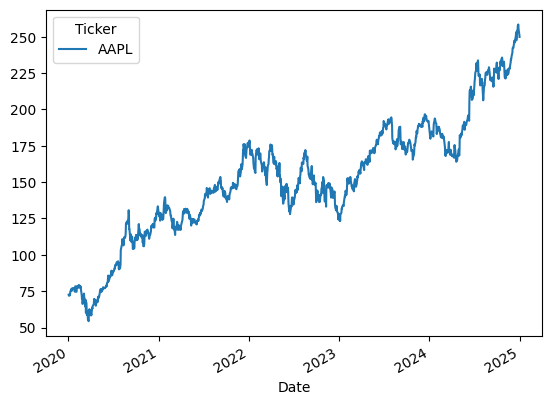

In [9]:
 df['Close'].plot()

In [10]:
df.sample(5)

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-03-15,171.583725,171.583725,169.267711,170.142433,121664700
2024-12-02,239.013428,240.210537,236.589283,236.699019,48137100
2020-09-21,107.198296,107.305417,100.401017,101.803322,195713800
2024-03-12,172.190079,172.985279,169.983404,172.110557,59825400
2024-05-31,191.355103,191.673620,189.025999,190.548875,75158300


In [11]:
df['Close'].shape

(1258, 1)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()
df['Close']=scaler.fit_transform(df['Close'])

In [14]:
seq_length = 30
data=[]

for i in range(len(df)-seq_length):
  data.append(df['Close'][i:i+seq_length])
data = np.array(data)

In [15]:
data.shape

(1228, 30, 1)

In [16]:
train_size= int(len(data)*0.8)
X_train = torch.from_numpy(data[:train_size,:-1:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:,-1:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)

In [17]:
class PredictionModule(nn.Module):
  def __init__( self, input_dim , hidden_dim , num_layers , output_dim ):
    super(PredictionModule,self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_dim,output_dim)

  def forward(self,x):
    h0= torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
    c0= torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
    out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
    out = self.fc(out[:,-1,:])
    return out

In [18]:
model = PredictionModule(input_dim=1,hidden_dim=64,num_layers=2,output_dim=1)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [19]:
num_epochs =100
for i in range(num_epochs):
  y_train_pred = model(X_train)

  loss = criterion(y_train_pred,y_train)
  print(f'Epoch: {i+1}, Loss: {loss.item()}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch: 1, Loss: 0.6664957404136658
Epoch: 2, Loss: 0.512736439704895
Epoch: 3, Loss: 0.4348534643650055
Epoch: 4, Loss: 0.22415146231651306
Epoch: 5, Loss: 0.09041706472635269
Epoch: 6, Loss: 0.13689102232456207
Epoch: 7, Loss: 0.15226930379867554
Epoch: 8, Loss: 0.09842219203710556
Epoch: 9, Loss: 0.04806528240442276
Epoch: 10, Loss: 0.0636267364025116
Epoch: 11, Loss: 0.046348728239536285
Epoch: 12, Loss: 0.04441801831126213
Epoch: 13, Loss: 0.04204240068793297
Epoch: 14, Loss: 0.03565622493624687
Epoch: 15, Loss: 0.027782881632447243
Epoch: 16, Loss: 0.020168486982584
Epoch: 17, Loss: 0.01610666885972023
Epoch: 18, Loss: 0.014339562505483627
Epoch: 19, Loss: 0.018475128337740898
Epoch: 20, Loss: 0.01714012213051319
Epoch: 21, Loss: 0.013706870377063751
Epoch: 22, Loss: 0.016078351065516472
Epoch: 23, Loss: 0.014317100867629051
Epoch: 24, Loss: 0.012675059027969837
Epoch: 25, Loss: 0.011574195697903633
Epoch: 26, Loss: 0.008112129755318165
Epoch: 27, Loss: 0.00819943007081747
Epoch: 

Test Loss: 0.9313773512840271
Root Mean Squared Error (RMSE): 40.53459930419922


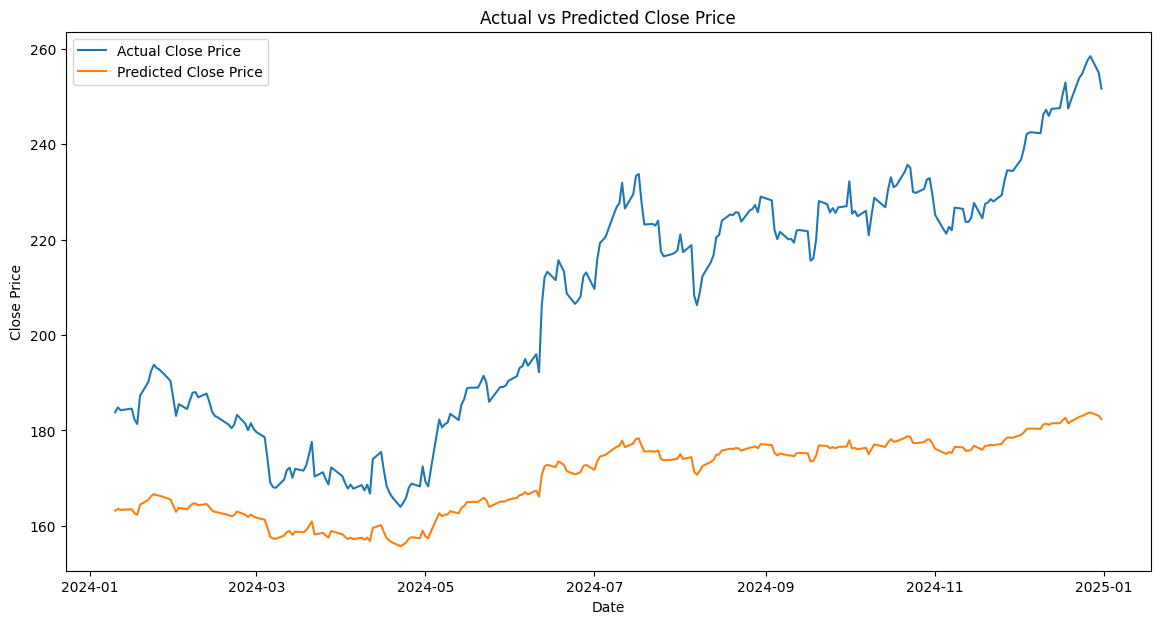

In [ ]:
import matplotlib.pyplot as plt
with torch.no_grad():
  y_test_pred = model(X_test)
  test_loss = criterion(y_test_pred, y_test)
  print(f'Test Loss: {test_loss.item()}')

  # Inverse transform the scaled data for plotting and accuracy calculation
  y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())
  y_test_predicted = scaler.inverse_transform(y_test_pred.cpu().numpy())

  # Calculate RMSE (accuracy metric for regression)
  rmse = root_mean_squared_error(y_test_actual, y_test_predicted)
  print(f'Root Mean Squared Error (RMSE): {rmse}')

  # Create plot of actual vs predicted
  plt.figure(figsize=(14, 7))
  plt.plot(df.index[train_size + seq_length:], y_test_actual, label='Actual Close Price')
  plt.plot(df.index[train_size + seq_length:], y_test_predicted, label='Predicted Close Price')
  plt.title('Actual vs Predicted Close Price')
  plt.xlabel('Date')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()

# OPTUNA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.5 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
[I 2025-05-27 15:08:08,126] A new study created in memory with name: no-name-56ef1b50-d090-4dae-bdc8-d7f2a40c630d
[I 2025-05-27 15:08:08,581] Trial 0 finished with value: 0.4746516942977905 and parameters: {'hidden_dim': 48, 'num_layers': 3, 'lr': 0.0008849214250814094}. Best is trial 0 with value: 0.4746516942977905.
[I 2025-05-27 15:08:10,089] Trial 1 finished with value: 0.7969628572463989 and parameters: {'hidden_dim': 112, 'num_layers': 3, 'lr': 0.0003826889696788832}. Best is trial 0 with value: 0.4746516942977905.
[I 2025-05-27 15:08:11,196] Trial 2 finished with value: 1.0278029441833496 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'lr': 0.00023941675414345677}. Best is trial 0 with value: 0.4746516942977905.
[I 2025-05-27 15:08:11,465] Trial 3 finished with value: 2.138270139694214 and parameters: {'hidden_dim': 96, 'num_layers': 1, 'lr': 1.9978849076850425e-05}. Best is trial 0 with value: 0.47465169


Best hyperparameters found by Optuna:
{'hidden_dim': 128, 'num_layers': 3, 'lr': 0.005844442970455062}

Best test loss:
0.016685787588357925

Training final model with best parameters: hidden_dim=128, num_layers=3, lr=0.005844442970455062
Final Model Epoch: 1, Loss: 0.6487789154052734
Final Model Epoch: 20, Loss: 0.031595177948474884
Final Model Epoch: 40, Loss: 0.005538612604141235
Final Model Epoch: 60, Loss: 0.00374444923363626
Final Model Epoch: 80, Loss: 0.003033618675544858
Final Model Epoch: 100, Loss: 0.0026037655770778656
Final Model Epoch: 120, Loss: 0.0021979750599712133
Final Model Epoch: 140, Loss: 0.0018112630350515246
Final Model Epoch: 160, Loss: 0.0014373566955327988
Final Model Epoch: 180, Loss: 0.0010778829455375671
Final Model Epoch: 200, Loss: 0.0007371778483502567

Final Model Test Loss: 0.00707244360819459
Final Model Root Mean Squared Error (RMSE): 3.532219886779785


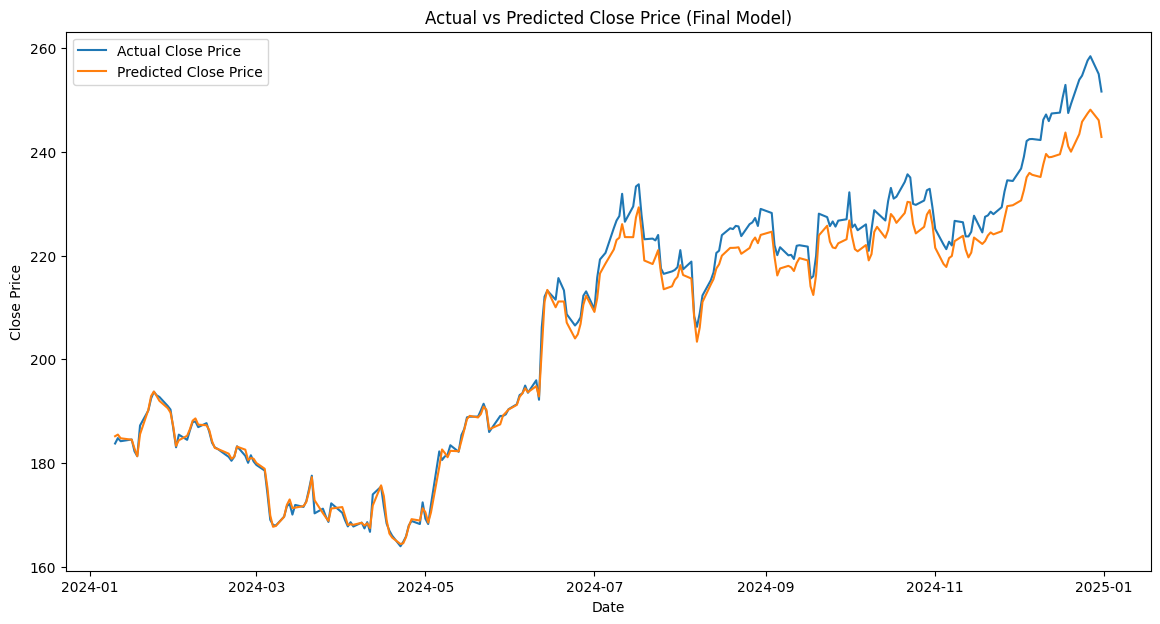

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

# Install Optuna if not already installed
!pip install optuna
import optuna

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import yfinance as yf
ticker = 'AAPL'
startdate = '2020-01-01'
enddate = '2025-01-01'
df= yf.download(ticker,start=startdate,end=enddate)

scaler = StandardScaler()
df['Close']=scaler.fit_transform(df[['Close']])

seq_length = 30
data=[]

for i in range(len(df)-seq_length):
  data.append(df['Close'][i:i+seq_length].values)

data = np.array(data)

train_size= int(len(data)*0.8)
X_train = torch.from_numpy(data[:train_size,:,:]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:,:,:]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[train_size:,-1,:]).type(torch.Tensor).to(device)

class PredictionModule(nn.Module):
  def __init__( self, input_dim , hidden_dim , num_layers , output_dim ):
    super(PredictionModule,self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_dim,output_dim)

  def forward(self,x):
    h0= torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
    c0= torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
    out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
    out = self.fc(out[:,-1,:])
    return out

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    hidden_dim = trial.suggest_int('hidden_dim', 16, 128, step=16) # Suggest hidden_dim between 16 and 128, in steps of 16
    num_layers = trial.suggest_int('num_layers', 1, 4)           # Suggest num_layers between 1 and 4
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)      # Suggest learning rate on a logarithmic scale

    # Create the model with suggested hyperparameters
    model = PredictionModule(input_dim=X_train.shape[-1],
                             hidden_dim=hidden_dim,
                             num_layers=num_layers,
                             output_dim=y_train.shape[-1]).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop (simplified for hyperparameter tuning)
    num_epochs = 50 # Reduce epochs for faster tuning, adjust as needed
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    # Return the metric to minimize (test loss)
    return test_loss.item()

# 'minimize' because we want to minimize the test loss
study = optuna.create_study(direction='minimize')
# n_trials: number of different hyperparameter combinations to try
study.optimize(objective, n_trials=50) # You can increase n_trials for better results

# Print the best hyperparameters and the corresponding best score (test loss)
print("\nBest hyperparameters found by Optuna:")
print(study.best_params)
print("\nBest test loss:")
print(study.best_value)

# You can now train your final model using the best hyperparameters found
best_hidden_dim = study.best_params['hidden_dim']
best_num_layers = study.best_params['num_layers']
best_lr = study.best_params['lr']

print(f"\nTraining final model with best parameters: hidden_dim={best_hidden_dim}, num_layers={best_num_layers}, lr={best_lr}")

final_model = PredictionModule(input_dim=X_train.shape[-1],
                               hidden_dim=best_hidden_dim,
                               num_layers=best_num_layers,
                               output_dim=y_train.shape[-1]).to(device)

final_criterion = nn.MSELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=best_lr)

# Train the final model for more epochs
final_num_epochs = 200 # Use original or more epochs for the final model
for epoch in range(final_num_epochs):
    final_model.train()
    final_optimizer.zero_grad()
    outputs = final_model(X_train)
    loss = final_criterion(outputs, y_train)
    if (epoch + 1) % 20 == 0 or epoch == 0: # Print loss periodically
        print(f'Final Model Epoch: {epoch+1}, Loss: {loss.item()}')
    loss.backward()
    final_optimizer.step()

# Evaluate the final model and plot
final_model.eval()
with torch.no_grad():
  y_test_pred = final_model(X_test)
  test_loss = final_criterion(y_test_pred, y_test)
  print(f'\nFinal Model Test Loss: {test_loss.item()}')

  # Inverse transform the scaled data
  y_test_actual = scaler.inverse_transform(y_test.cpu().numpy())
  y_test_predicted = scaler.inverse_transform(y_test_pred.cpu().numpy())

  # Calculate RMSE
  rmse = root_mean_squared_error(y_test_actual, y_test_predicted)
  print(f'Final Model Root Mean Squared Error (RMSE): {rmse}')

  # Create plot of actual vs predicted
  plt.figure(figsize=(14, 7))
  plt.plot(df.index[train_size + seq_length:], y_test_actual, label='Actual Close Price')
  plt.plot(df.index[train_size + seq_length:], y_test_predicted, label='Predicted Close Price')
  plt.title('Actual vs Predicted Close Price (Final Model)')
  plt.xlabel('Date')
  plt.ylabel('Close Price')
  plt.legend()
  plt.show()